In [1]:
import os
import torch
import math
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import logging
from torch.utils.tensorboard import SummaryWriter

In [2]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%I:%M:%S",
)


def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)

# Data Preprocessing

In [3]:
from data.one_hot_descrete import DiscreteOneHotEncoder
from torch.utils.data import DataLoader


# data = pd.read_csv("./data/nts_2021_acts_home_based.csv")
data = pd.read_csv("./data/nts_toy_home_population.csv")

encoder = DiscreteOneHotEncoder(step_size=30)
encoded_data = encoder.encode(data)
print(encoder.acts_to_index)

dataloader = DataLoader(
    encoded_data,
    batch_size=12,
    num_workers=3,
    shuffle=True,
    persistent_workers=True,
)

{'home': 0, 'visit': 1, 'other': 2, 'escort': 3, 'shop': 4, 'work': 5, 'education': 6, 'medical': 7}


In [4]:
(x, x_mask) = encoded_data[10]
x.shape

torch.Size([1, 48, 8])

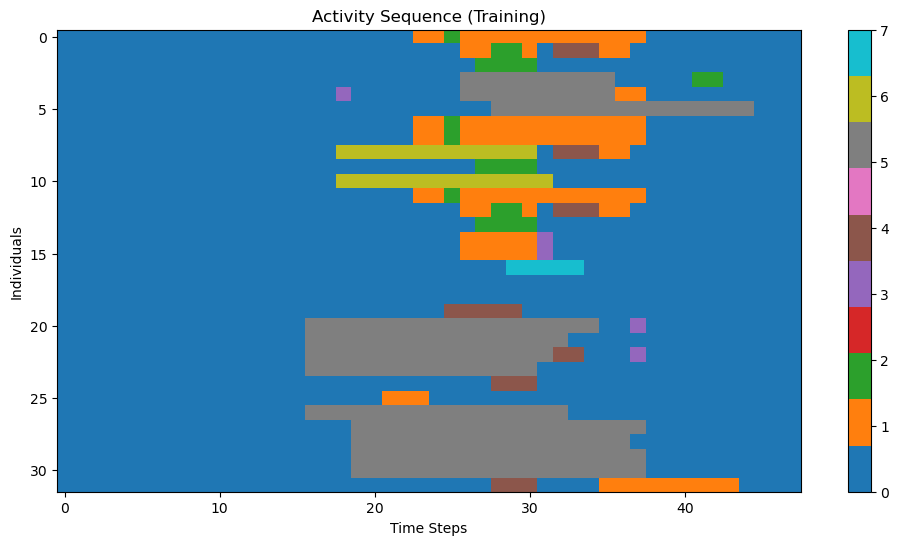

In [5]:
def plot_image_grid(image_grid, title="Activity Sequence (Training)"):
    plt.figure(figsize=(12, 6))
    plt.imshow(image_grid, aspect="auto", cmap="tab10")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Individuals")
    plt.show()


sample = [encoded_data[i][0].squeeze().argmax(dim=-1) for i in range(32)]
plot_image_grid(sample)

# Diffusion

In [6]:
class Diffusion:
    def __init__(
        self,
        noise_steps=25,
        beta_start=0.0001,
        beta_end=0.02,
        sequence_length=144,
        device="cuda",
    ):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.sequence_length = sequence_length
        self.device = device

        self.beta = self.schedule_noise().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def schedule_noise(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_embeddings(self, embeddings, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat[t])[:, None, None]

        epsilon = torch.randn_like(embeddings)

        noisy_embeddings = (
            sqrt_alpha_hat * embeddings + sqrt_one_minus_alpha_hat * epsilon
        )

        # Debug: Check for NaNs
        if torch.isnan(noisy_embeddings).any():
            print("NaNs detected in noisy_embeddings")
            print("sqrt_alpha_hat:", sqrt_alpha_hat)
            print("sqrt_one_minus_alpha_hat:", sqrt_one_minus_alpha_hat)
            print("epsilon:", epsilon)

        return noisy_embeddings.float(), epsilon.float()

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, embedding_dim):
        logging.info(f"Sampling {n} new sequences...")
        model.eval()
        with torch.no_grad():
            # Initialise x with the proper dimensions for sequence data.
            x = torch.randn((n, self.sequence_length, embedding_dim)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                # Adjust dimensions for alpha, alpha_hat, and beta to match x
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]

                if i > 2:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = (1 / torch.sqrt(alpha)) * (
                    x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise
                ) + torch.sqrt(beta) * noise

        model.train()
        return x

# Transformer

In [13]:
from models.cnn import Conv
from models.transformer import TransformerWithPositionalEncoding


def setup_logging(run_name):
    logging.basicConfig(level=logging.INFO)


def train(model, diffusion):
    run_name = "first_run"
    device = "cpu"
    learning_rate = 0.001
    epochs = 500

    setup_logging(run_name)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    x_entropy = nn.CrossEntropyLoss()
    logger = SummaryWriter(os.path.join("runs", run_name))

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}")
        epoch_loss = 0.0
        # for batch_idx, (x,) in enumerate(tqdm(dataloader)):
        for batch_idx, (x, x_mask) in enumerate(tqdm(dataloader)):
            x = x.squeeze(1)
            embedded_x = x.to(device)

            optimizer.zero_grad()
            timesteps = torch.randint(
                0, diffusion.noise_steps, (embedded_x.size(0),), device=device
            )
            embedded_x = embedded_x.float()
            noisy_x, _ = diffusion.noise_embeddings(embedded_x, timesteps)
            predicted_x = model(noisy_x, timesteps)

            loss = x_entropy(predicted_x.permute(0, 2, 1), noisy_x.argmax(dim=-1))

            loss.backward(retain_graph=True)
            optimizer.step()
            epoch_loss += loss.item()

            # Log training loss to TensorBoard every 10 batches
            if batch_idx % 10 == 0:
                logger.add_scalar(
                    "Loss/train", loss.item(), epoch * len(dataloader) + batch_idx
                )

        avg_epoch_loss = epoch_loss / len(dataloader)
        logging.info(f"Epoch {epoch} Average Loss: {avg_epoch_loss}")
        logger.add_scalar("Loss/epoch_avg_train", avg_epoch_loss, epoch)

    logger.close()


# KEEP the trained model and diffusion for sampling!!!
model = TransformerWithPositionalEncoding(num_layers=3, max_time_steps=48).to("cpu")
# model = Conv(in_shape=(48, 8), hidden_layers=(32, 32), dropout=0.1)
diffusion = Diffusion(
    noise_steps=25, beta_start=0.0001, beta_end=0.02, sequence_length=48, device="cpu"
)

train(model, diffusion)

11:35:23 - INFO: Starting epoch 0
100%|██████████| 3/3 [00:00<00:00, 32.70it/s]
11:35:23 - INFO: Epoch 0 Average Loss: 1.8867387771606445
11:35:23 - INFO: Starting epoch 1
100%|██████████| 3/3 [00:00<00:00, 33.42it/s]
11:35:23 - INFO: Epoch 1 Average Loss: 1.7833529313405354
11:35:23 - INFO: Starting epoch 2
100%|██████████| 3/3 [00:00<00:00, 41.21it/s]
11:35:23 - INFO: Epoch 2 Average Loss: 1.7583471934000652
11:35:23 - INFO: Starting epoch 3
100%|██████████| 3/3 [00:00<00:00, 45.58it/s]
11:35:23 - INFO: Epoch 3 Average Loss: 1.7355839014053345
11:35:23 - INFO: Starting epoch 4
100%|██████████| 3/3 [00:00<00:00, 42.97it/s]
11:35:23 - INFO: Epoch 4 Average Loss: 1.707027276357015
11:35:23 - INFO: Starting epoch 5
100%|██████████| 3/3 [00:00<00:00, 47.75it/s]
11:35:23 - INFO: Epoch 5 Average Loss: 1.672617793083191
11:35:23 - INFO: Starting epoch 6
100%|██████████| 3/3 [00:00<00:00, 45.58it/s]
11:35:23 - INFO: Epoch 6 Average Loss: 1.6176167726516724
11:35:23 - INFO: Starting epoch 7
10

In [14]:
# After generating new sequences using the diffusion model
generated_sequences = diffusion.sample(model=model, n=32, embedding_dim=8)

# Map the generated sequences back to discrete activities
discrete_activities = generated_sequences.argmax(dim=-1)

11:35:57 - INFO: Sampling 32 new sequences...
24it [00:00, 79.95it/s]


In [15]:
# Decode each activity index back to its label
decoded_sequences = [
    [encoder.index_to_acts[index.item()] for index in sequence]
    for sequence in discrete_activities
]

In [16]:
df_decoded = pd.DataFrame(
    decoded_sequences, columns=[f"Step {i}" for i in range(len(decoded_sequences[0]))]
)
df_decoded.head(5)

,Step 0,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,...,Step 38,Step 39,Step 40,Step 41,Step 42,Step 43,Step 44,Step 45,Step 46,Step 47
0,other,work,other,other,other,work,other,other,other,shop,...,other,other,other,other,medical,other,other,other,other,other
1,work,visit,other,other,work,work,other,other,work,work,...,other,work,other,other,work,work,visit,medical,work,other
2,work,other,other,other,other,other,other,work,work,work,...,shop,other,work,work,other,other,work,other,other,other
3,work,medical,medical,other,work,work,work,other,shop,other,...,medical,other,other,other,work,work,medical,escort,medical,other
4,other,other,other,work,other,other,work,other,other,other,...,other,other,medical,other,other,other,other,other,medical,other


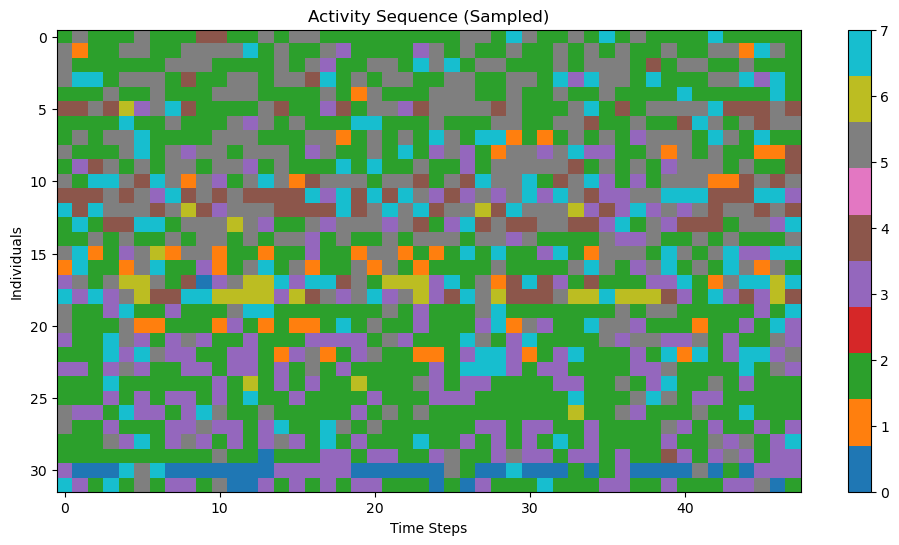

In [17]:
plot_image_grid(discrete_activities, title="Activity Sequence (Sampled)")